# Movie Recommendation System

In this notebook i will try to implement recommendation algorithm (content based filtering) and i will aslo attempt at giving some insights about the data. With us we have TMDb movie dataset :
    This data set contains information
    about 10,000 movies collected from
    The Movie Database (TMDb),
    including user ratings and revenue.
    
   
    ● The dataset contains full credits 
    for both the cast and the crew,
    rather than just the first three actors.
    
    ●Actor and actresses are now listed in
    the order they appear in the credits.
    
    ●The final two columns ending with “_adj”
    show the budget and revenue of the 
    associated movie in terms of 2010 dollars
    , accounting for inflation over time.
    
    ● The revenues appear to be more current.
    For example, IMDB's figures for Avatar 
    seem to be from 2010 and understate the 
    film's global revenues by over $2 billion.
    
    


In [45]:
#important libraries
import pandas as pd
import numpy as np
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
df = pd.read_csv("tmdb-movies1.csv")
df.head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,06 09 15,5562,6.5,2015,137999939.3,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,137999939.3,3.481613e+08


In [47]:
df.shape

(10866, 21)

In [48]:
df.dtypes

id                        int64
imdb_id                  object
popularity              float64
budget                    int64
revenue                   int64
original_title           object
cast                     object
homepage                 object
director                 object
tagline                  object
keywords                 object
overview                 object
runtime                   int64
genres                   object
production_companies     object
release_date             object
vote_count                int64
vote_average            float64
release_year              int64
budget_adj              float64
revenue_adj             float64
dtype: object

The number of moviess we have is 10866 movies with 21 feature columns we want to invistigate wether these columns is helpful for the recommendation preocess or not.

Also there is some columns that do not need invistigation which will not be useful for the process.

These columns are id,imdb_id,homepage and tagline.
i will also focus on catigorical variables so i will remove most of numarical values

In [49]:
columns_drop = ["id","imdb_id","homepage","tagline","budget","revenue","release_date",
                "budget_adj"]
df.drop(columns_drop,axis=1,inplace=True)
df.shape

(10866, 13)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   popularity            10866 non-null  float64
 1   original_title        10866 non-null  object 
 2   cast                  10790 non-null  object 
 3   director              10822 non-null  object 
 4   keywords              9373 non-null   object 
 5   overview              10862 non-null  object 
 6   runtime               10866 non-null  int64  
 7   genres                10843 non-null  object 
 8   production_companies  9836 non-null   object 
 9   vote_count            10866 non-null  int64  
 10  vote_average          10866 non-null  float64
 11  release_year          10866 non-null  int64  
 12  revenue_adj           10866 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 1.1+ MB


From this we that some columns have null values like cast, director and 
production_companies.
but i will not drop the null alues them untill i see if the columns have
useful information or not

In [51]:
df.describe()

,popularity,runtime,vote_count,vote_average,release_year,revenue_adj
count,10866.000000,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04
mean,0.646441,102.070863,217.389748,5.974922,2001.322658,5.136436e+07
std,1.000185,31.381405,575.619058,0.935142,12.812941,1.446325e+08
min,0.000065,0.000000,10.000000,1.500000,1960.000000,0.000000e+00
25%,0.207583,90.000000,17.000000,5.400000,1995.000000,0.000000e+00
50%,0.383856,99.000000,38.000000,6.000000,2006.000000,0.000000e+00
75%,0.713817,111.000000,145.750000,6.600000,2011.000000,3.369710e+07
max,32.985763,900.000000,9767.000000,9.200000,2015.000000,2.827124e+09


From this table we can observe to outliers we want to invistigate about :
 - the first in runtime column which have a vlaue of 900 minutes
 - vote_count over 9767 
 
The best way to ivistigate them by plotting histograms.

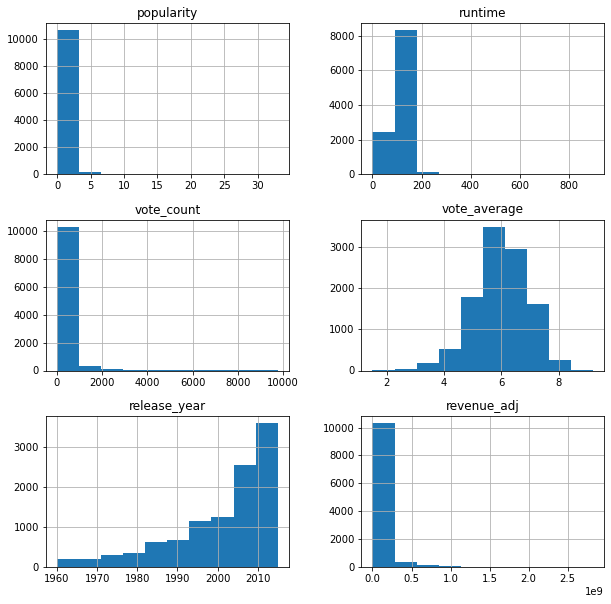

In [52]:
df.hist(figsize=(10,10));

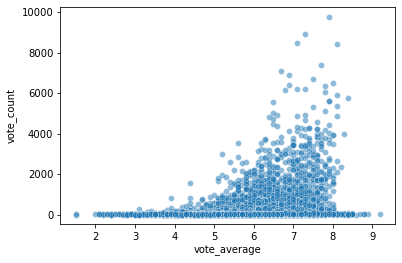

In [53]:
_ = sns.scatterplot(y=df.vote_count,x=df.vote_average,alpha=.5)

From th figure we can conclude that movies with higher vote average almost have high vote_count

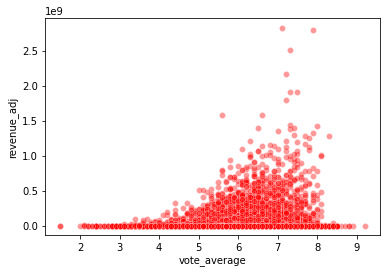

In [54]:
_ = sns.scatterplot(y=df.revenue_adj,x=df.vote_average,alpha=.4,color="red")

There is no relationship bewtween vote_average and revenue_adj as not I am expected.

- movies with high rating between 8.3 and 9 almost earned the same revenues as movies between 1 and 4 
    I am surpreised 
- but movies having rate betwenn 6.5 and 8 have higher revenues than the others 

In [55]:
#check for duolicates
df.duplicated().sum()

1

In [56]:
df[df.duplicated(keep=False)]

,popularity,original_title,cast,director,keywords,overview,runtime,genres,production_companies,vote_count,vote_average,release_year,revenue_adj
2089,0.59643,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...,Dwight H. Little,martial arts|dystopia|based on video game|mart...,"In the year of 2039, after World Wars destroy ...",92,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,110,5.0,2010,967000.0
2090,0.59643,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...,Dwight H. Little,martial arts|dystopia|based on video game|mart...,"In the year of 2039, after World Wars destroy ...",92,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,110,5.0,2010,967000.0


it is a duplicated value not a similar name or something like that so we drop it

In [57]:
df.drop_duplicates(inplace=True)

Remove every special characters in the original_title in the movie to facilitate input the data

like The Godfather: Part 2 will be The Godfather Part 2 with no : in between.

In [58]:
df["original_title"] = df["original_title"].apply(
    lambda x : re.sub('[^a-zA-Z.\d\s]', '', x).lower())
df.head(1)

,popularity,original_title,cast,director,keywords,overview,runtime,genres,production_companies,vote_count,vote_average,release_year,revenue_adj
0,32.985763,jurassic world,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,5562,6.5,2015,1.392446e+09


Cleaning columns that contain "|" in their records like in cast , genres and production_companies

In [59]:
cols = ["cast","genres", "production_companies","keywords"]
'''create a function to check if the given redord have a null value or not
   as split function dose not work with null value and i do not want to 
   movies with null values in thier columns '''
def dele(x):
    if isinstance(x, str) :
        return x.split("|")
    else : pass  
        
for c in cols:
    df[c] = df[c].apply(lambda x : dele(x))
df.head(1)

,popularity,original_title,cast,director,keywords,overview,runtime,genres,production_companies,vote_count,vote_average,release_year,revenue_adj
0,32.985763,jurassic world,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",Colin Trevorrow,"[monster, dna, tyrannosaurus rex, velociraptor...",Twenty-two years after the events of Jurassic ...,124,"[Action, Adventure, Science Fiction, Thriller]","[Universal Studios, Amblin Entertainment, Lege...",5562,6.5,2015,1.392446e+09


In [60]:
df_c = df.copy()
df_c = df_c.explode("genres")
df.head(1)

,popularity,original_title,cast,director,keywords,overview,runtime,genres,production_companies,vote_count,vote_average,release_year,revenue_adj
0,32.985763,jurassic world,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",Colin Trevorrow,"[monster, dna, tyrannosaurus rex, velociraptor...",Twenty-two years after the events of Jurassic ...,124,"[Action, Adventure, Science Fiction, Thriller]","[Universal Studios, Amblin Entertainment, Lege...",5562,6.5,2015,1.392446e+09


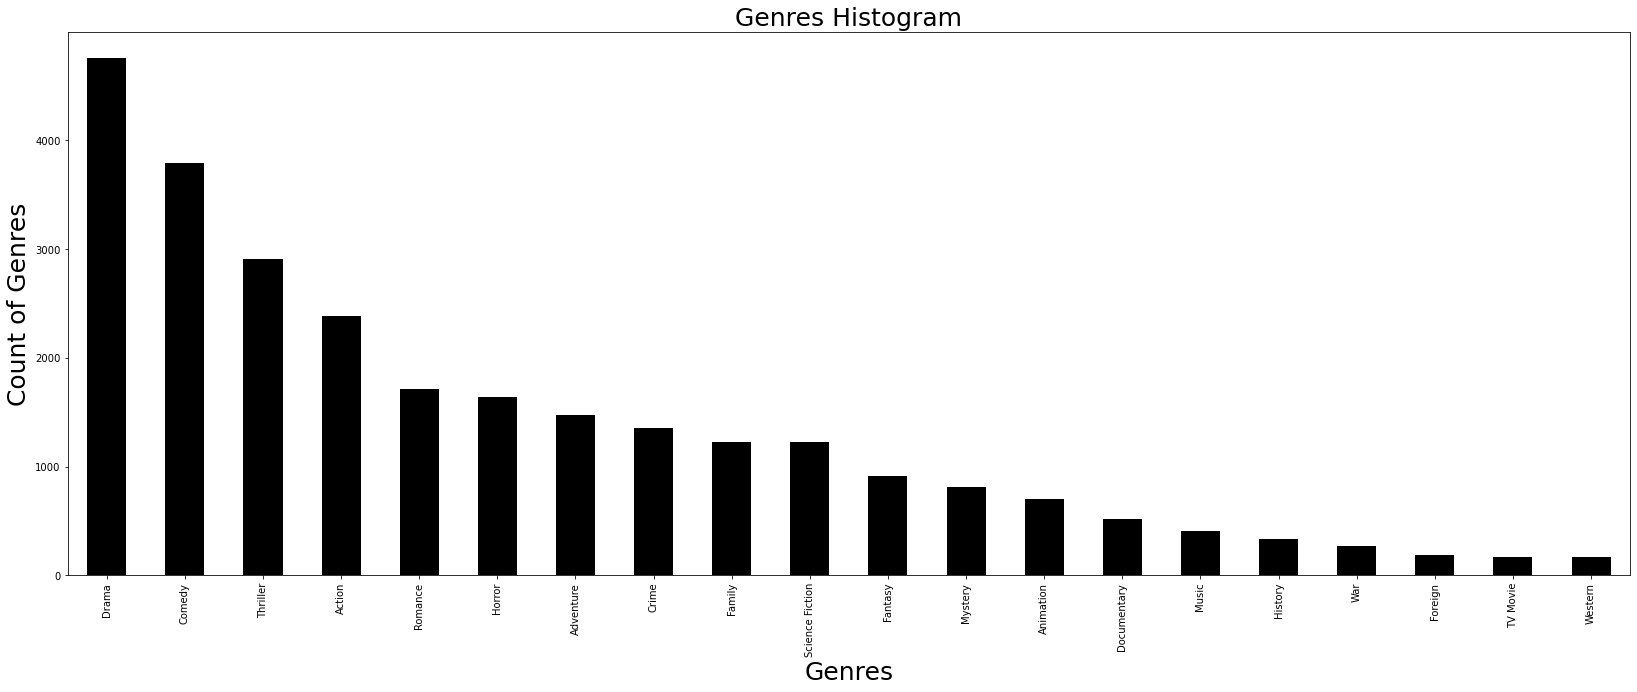

In [61]:
df_c["genres"].value_counts().plot(kind="bar",figsize=(28,10),color="black");
plt.xlabel("Genres",fontsize =25);
plt.ylabel("Count of Genres",fontsize =25)
plt.title("Genres Histogram",fontsize =25);

Here we see gennres column is exploded and movie column has repeated records where each movie has multiple values for genres

create a copy dataframe to invistigate which is the most popular column

Drama is most commom genre where Western is the lowest




Now,transform Genres column into coded values of one for fitting the algorithm and invistigating

In [62]:
#first fill null values of a string to avoid null values error
df.genres.fillna("",inplace = True)
df.keywords.fillna("",inplace=True)
df.cast.fillna("",inplace=True)
df.production_companies.fillna("s",inplace=True)
df.director.fillna("",inplace = True)
df.overview.fillna("",inplace=True)

To personalise our recommendations more, I am going to build an engine that computes similarity between movies based on cast and keywords

for instance, if someone liked Iron man movie, he may be interested in marvel movies.

The same for keywords, if someone liked a movies with spy and undercover keywords in it, he may be interested in all spy movies.

In [63]:
''' Buid a function that takes a column as a given input which contains a list as record value
    and then takes the top 3 values in it'''
def split_dataframe(subject):
    df[subject] = df[subject].apply(lambda x : x[:3])
    return df[subject]

In [64]:
cols = ["cast","keywords"]
for c in cols:
    split_dataframe(cols)
df.head(2)

,popularity,original_title,cast,director,keywords,overview,runtime,genres,production_companies,vote_count,vote_average,release_year,revenue_adj
0,32.985763,jurassic world,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",Colin Trevorrow,"[monster, dna, tyrannosaurus rex, velociraptor...",Twenty-two years after the events of Jurassic ...,124,"[Action, Adventure, Science Fiction, Thriller]","[Universal Studios, Amblin Entertainment, Lege...",5562,6.5,2015,1.392446e+09
1,28.419936,mad max fury road,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...",George Miller,"[future, chase, post-apocalyptic, dystopia, au...",An apocalyptic story set in the furthest reach...,120,"[Action, Adventure, Science Fiction, Thriller]","[Village Roadshow Pictures, Kennedy Miller Pro...",6185,7.1,2015,3.481613e+08


In [65]:
#remove popularity,runtime,vote_count and revenue_adj as i will not need them in the recommendtion process
columns_drop = ["popularity","runtime","vote_count", "revenue_adj"]
df.drop(columns_drop,axis=1,inplace=True)
df.shape

(10865, 9)

Create a function to make strings records in lower cases and also remove spaces so when we use CountVectorizer varibles like Tom Curse and Tom Hardy will not be the same

In [69]:
def cleaning_data(x):
    if isinstance(x, list):
        #remove spaces so we can join them when creating soup
        return [str.lower(i.replace(" ", "")) for i in x] 
    else:
        #Check if a record exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", "")) # for directors column
        else:
            return ''

In [67]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df[feature] = df[feature].apply(cleaning_data)
df.head(2)

,original_title,cast,director,keywords,overview,genres,production_companies,vote_average,release_year
0,jurassic world,"[chrispratt, brycedallashoward, irrfankhan, vi...",colintrevorrow,"[monster, dna, tyrannosaurusrex, velociraptor,...",Twenty-two years after the events of Jurassic ...,"[action, adventure, sciencefiction, thriller]","[Universal Studios, Amblin Entertainment, Lege...",6.5,2015
1,mad max fury road,"[tomhardy, charlizetheron, hughkeays-byrne, ni...",georgemiller,"[future, chase, post-apocalyptic, dystopia, au...",An apocalyptic story set in the furthest reach...,"[action, adventure, sciencefiction, thriller]","[Village Roadshow Pictures, Kennedy Miller Pro...",7.1,2015


 create our "metadata soup", which is a string that contains all the metadata that we want to feed 
 
 to our vectorizer (namely actors, director and keywords).

In [68]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df['soup'] = df.apply(create_soup, axis=1)
df.head(2)

,original_title,cast,director,keywords,overview,genres,production_companies,vote_average,release_year,soup
0,jurassic world,"[chrispratt, brycedallashoward, irrfankhan, vi...",colintrevorrow,"[monster, dna, tyrannosaurusrex, velociraptor,...",Twenty-two years after the events of Jurassic ...,"[action, adventure, sciencefiction, thriller]","[Universal Studios, Amblin Entertainment, Lege...",6.5,2015,monster dna tyrannosaurusrex velociraptor isla...
1,mad max fury road,"[tomhardy, charlizetheron, hughkeays-byrne, ni...",georgemiller,"[future, chase, post-apocalyptic, dystopia, au...",An apocalyptic story set in the furthest reach...,"[action, adventure, sciencefiction, thriller]","[Village Roadshow Pictures, Kennedy Miller Pro...",7.1,2015,future chase post-apocalyptic dystopia austral...


Use CountVectorizer to transform a soup column into a vector on the basis of the frequency (count) of each word that occurs in the entire text.

That will give  a matrix in which each unique word is represented by a column of the matrix, and each text sample from the document is a row in the matrix.

In [70]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['soup'])
count_matrix.shape

(10865, 5759)


compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the cosine similarity scores.

In [73]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim.shape

(10865, 10865)

In [71]:
#making a series with te indcies of the original title
df = df.reset_index()
indices = pd.Series(df.index, index=df['original_title'])
indices

original_title
jurassic world                     0
mad max fury road                  1
insurgent                          2
star wars the force awakens        3
furious 7                          4
                               ...  
the endless summer             10860
grand prix                     10861
beregis avtomobilya            10862
whats up tiger lily            10863
manos the hands of fate        10864
Length: 10865, dtype: int64

In [80]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie 
    index = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[index]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['original_title'].iloc[movie_indices]

In [82]:
get_recommendations("harry potter and the goblet of fire", cosine_sim)

73                                                    pan
1389                harry potter and the halfblood prince
1921                                  alice in wonderland
1923          harry potter and the deathly hallows part 1
1934    the chronicles of narnia the voyage of the daw...
1947     percy jackson  the olympians the lightning thief
2633              harry potter and the philosophers stone
2901              the chronicles of narnia prince caspian
2920                                             inkheart
2945                            the spiderwick chronicles
Name: original_title, dtype: object

The results are pretty satisfying as the engine recommended all Harry Potter movies and the rest are similar to them. 

In [83]:
#another process
get_recommendations("the dark knight rises", cosine_sim)

4362                           the dark knight rises
2289    across the line the exodus of charlie wright
6190                                   batman begins
9128                                       following
164                          kidnapping mr. heineken
473                                  lost in the sun
505                              landmine goes click
555                                      tiger house
684                              a most violent year
728                                   need for speed
Name: original_title, dtype: object

Making another engine with overview column, repeating the same process
- making the CountVectorizer to caculate frequencies
- then compute the similarity between the movies 
- then recommend beased on get_recommendations function

In [84]:
count = CountVectorizer(stop_words='english')
count_matrix2 = count.fit_transform(df['overview'])
count_matrix2.shape

(10865, 32786)

In [85]:
cosine_sim2 = cosine_similarity(count_matrix2, count_matrix2)
cosine_sim2.shape

(10865, 10865)

In [86]:
get_recommendations("harry potter and the goblet of fire", cosine_sim2)

1923    harry potter and the deathly hallows part 1
3373    harry potter and the deathly hallows part 2
6961       harry potter and the prisoner of azkaban
7387      harry potter and the order of the phoenix
1389          harry potter and the halfblood prince
3911        harry potter and the chamber of secrets
9221                                   miracle mile
7604                                   married life
1255                                   all relative
2633        harry potter and the philosophers stone
Name: original_title, dtype: object